In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
# CONFIG
PLAYER_DATA_DIR: Path = Path("./sample") # or use "./players" but note there are 9996 players and takes a lot of RAM usage!!!
SINGLE_FILE_DATA: Path = Path("./sample.db") # this should be ~300 mb
REPLAY_COUNT_LIMIT: int = 100
USE_DATASET: bool = False # set this to true for now since i do not plan to use the entire dataset of 9996 players

In [3]:
if USE_DATASET:
    conn = sqlite3.connect(SINGLE_FILE_DATA)
    scores = pd.read_sql_query("SELECT * FROM scores", conn)
    conn.close()
else:
    db_files: list = [p for p in PLAYER_DATA_DIR.iterdir() if p.is_file()] 
    scores = pd.DataFrame({})
    
    for player in db_files:
        conn = sqlite3.connect(player)
        score = pd.read_sql_query("SELECT * FROM scores", conn)
        scores = pd.concat([scores, score], ignore_index=True)
        conn.close()


In [4]:
players = scores['user_id'].unique()
print(f"Player count: {len(players)}")

Player count: 128


In [5]:
scores

,user_id,player_pp,date_unix,combo,max_combo_beatmap,total_score,accuracy,pp,stars,countNormal,countSlider,countSpinner,great,ok,meh,miss
0,10192242,8529.91,1494625346,222,222,717834,0.900932,3.737130,1.74326,125,10,8,122,20,1,0
1,10192242,8529.91,1494629306,62,249,472187,0.913522,0.845961,1.74838,16,89,1,94,8,1,3
2,10192242,8529.91,1494629541,66,404,185844,0.709420,0.425131,1.82622,103,126,1,139,59,27,5
3,10192242,8529.91,1494630783,81,281,356641,0.846995,0.802295,1.67191,32,90,0,96,20,4,2
4,10192242,8529.91,1494697735,179,276,594323,0.909722,2.204800,1.71847,66,72,6,126,13,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351668,9791892,10944.40,1709535191,169,647,605157,0.967514,93.753200,6.85388,319,152,1,453,11,0,8
2351669,9791892,10944.40,1709537487,195,315,333309,0.955651,204.680000,5.39475,153,79,1,220,8,0,5
2351670,9791892,10944.40,1710800302,328,1263,630832,0.943035,99.852400,5.00672,411,417,0,762,55,3,8
2351671,9791892,10944.40,1710800555,470,1364,666586,0.951892,138.069000,5.09086,375,453,0,772,48,1,7


In [6]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351673 entries, 0 to 2351672
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   player_pp          float64
 2   date_unix          int64  
 3   combo              int64  
 4   max_combo_beatmap  int64  
 5   total_score        int64  
 6   accuracy           float64
 7   pp                 float64
 8   stars              float64
 9   countNormal        int64  
 10  countSlider        int64  
 11  countSpinner       int64  
 12  great              int64  
 13  ok                 int64  
 14  meh                int64  
 15  miss               int64  
dtypes: float64(4), int64(12)
memory usage: 287.1 MB


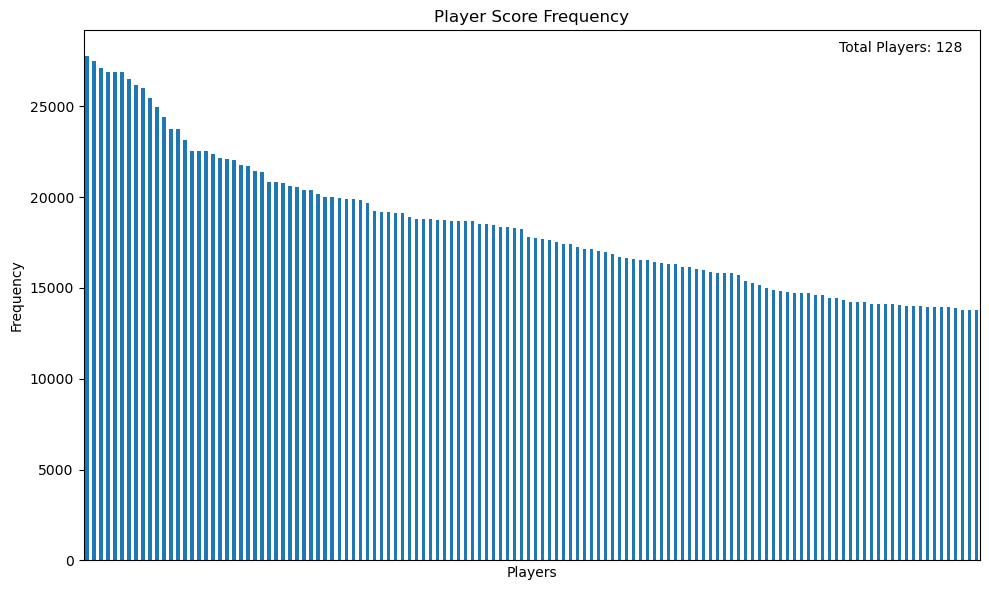

In [9]:
frequency = scores['user_id'].value_counts()

plt.figure(figsize=(10,6))
frequency.plot(kind='bar')
plt.title('Player Score Frequency')
plt.xlabel('Players')
plt.ylabel('Frequency')
plt.xticks([])
legend = f"Total Players: {len(frequency)}"
plt.text(0.98,0.98,legend, ha='right', va='top', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

In [74]:
def kmm_miss(players_list: list[int], kind: str) -> pd.DataFrame:
    kmm: pd.DataFrame = pd.DataFrame({
        'user_id' : [],
        'time' : [],
        'tally' : [],
    })

    index = -1
    match kind:
        case "miss": 
            index = 15
        case "meh":
            index = 14
        case "ok":
            index = 13
        case "great":
            index = 12

    
    for player in players_list:
        player_score = scores.loc[scores['user_id'] == player]
        data = {}
        counter = 0        
        for row in player_score.values:
            if row[index] == 0: # if there's no miss
                counter += 1
            else:
                if counter in data:
                    data[counter] += 1
                else:
                    data[counter] = 1
                counter = 0
        
        for d in data.items():
            kmm.loc[len(kmm.index)] = [player, d[0], d[1]]
          
    return kmm

def sort_kmm(data: pd.DataFrame) -> pd.DataFrame:
    return data.sort_values(by=['user_id', 'time'])
    

In [79]:
sort_kmm(kmm_miss([11172237], 'miss'))

,user_id,time,tally
0,11172237,0,3396
2,11172237,1,934
3,11172237,2,417
5,11172237,3,252
1,11172237,4,186
8,11172237,5,138
9,11172237,6,103
7,11172237,7,83
6,11172237,8,70
14,11172237,9,47


In [80]:
sort_kmm(kmm_miss(players, 'miss'))

,user_id,time,tally
2613,18983,0,4142
2614,18983,1,1502
2615,18983,2,700
2616,18983,3,360
2618,18983,4,211
...,...,...,...
2996,23635008,278,1
3004,23635008,307,1
2984,23635008,413,1
3008,23635008,487,1
